In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import matplotlib
import glob
import skimage.io as skio
import xgboost as xgb
import os
import shutil
import multiprocessing as mp
from itertools import repeat
import tifffile as ti
import csv

import torch
from collections import OrderedDict


from model import ResNet50
from utils.loss_function import *
from utils.accuracy import *
from utils.dataset import *
from utils.array import *

from utils.dataset import TrainingDataset

matplotlib.rcParams['figure.figsize'] = [10, 10]

In [2]:
folder = "/mnt/external.data/TowbinLab/kstojanovski/20220221_Ti2_10x_wBT160-263-182-258_25C_20220221_170003_134/analysis/"
def make_prediction(net,
                np_array,
                device,
                dim = 512,
                binary = True):
    
    # Preprocess on the image
    img = torch.from_numpy(TrainingDataset.preprocess_img_or_msk(np_array, dim))
    img = img.unsqueeze(0).to(device=device, dtype=torch.float32)

    # Work on the 
    with torch.no_grad():
        output = torch.softmax(net(img), dim = 1)
        return output

def load_model(model_path, n_classes):
    # Load U-Net
    # net = UNet(n_channels = 2, n_classes = n_classes)
    # Load NestedUNET
    net = ResNet50(n_classes, 1)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(model_path, map_location=device)
    net.to(device=device)

    state_dict = checkpoint['model_state_dict']
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    
    net.load_state_dict(new_state_dict)

    return {'net': net, 'device':device, 'epoch':checkpoint['epoch']}

In [3]:
labels = ["moulting", "not_moulting"]
net = load_model("./checkpoints/CP_epoch11.pth", 2)
# net = load_model("./checkpoints/best_network.pth", 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
fluo_path = folder + "ch2/"
images = [os.path.join(fluo_path, x) for x in os.listdir(fluo_path)]

image_titles = [os.path.basename(x) for x in images]

points = [x.split("_")[1] for x in image_titles]
unique_points = np.unique(points).tolist()

point_list = [x for x in unique_points]

point = point_list[3]

def list_images_of_point(videos, point):
    video_titles = []
    for video in videos:
        if point in os.path.basename(video):
            video_titles.append(video)
    return video_titles

videos_of_point = sorted(list_images_of_point(images, point))
# time_list = list_times(images, point)
# images_to_study = []

# for time in time_list:
#     name = os.path.join(fluo_path, time + "_" + point + "_Channel470.tiff")
#     images_to_study.append(name)

# # print(sorted(images_to_study))

trajectory = []
for i, img in enumerate(videos_of_point):
    print(i)
    img = ti.imread(img)

    pred = make_prediction(net['net'], img, device, dim = 1184)

    max_idx = torch.argmax(pred, keepdim=False)

    label = labels[max_idx]

    if label == "moulting":
        trajectory.append(0)
    elif label == "not_moulting":
        trajectory.append(1)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

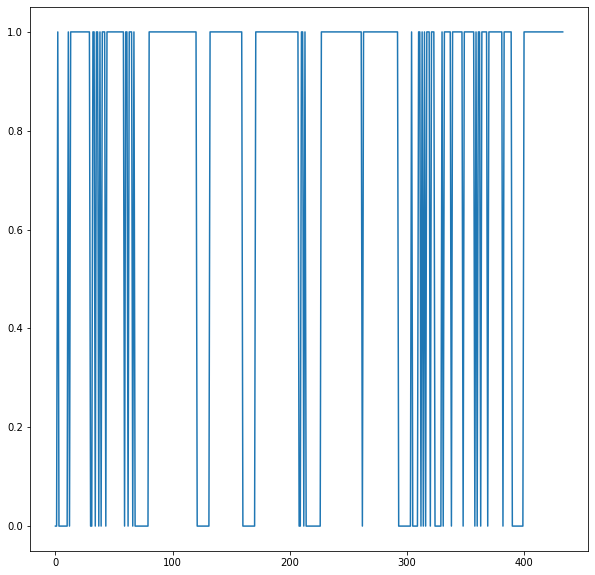

In [5]:
plt.plot(trajectory)

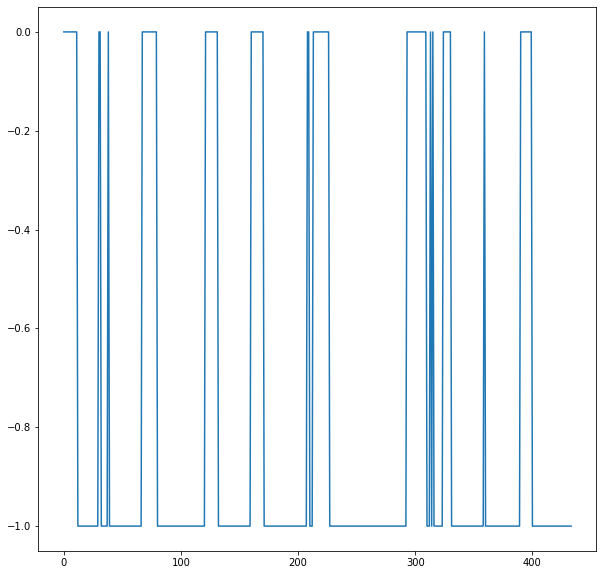

In [6]:
from scipy import signal

clean_traj = signal.medfilt(trajectory, 3)
plt.plot(-clean_traj)


In [7]:
def find_consecutive(l, min_width):
    consecutives = []
    for i, e in enumerate(l):
        if i == 0 or l[i - 1] != (e - 1):
            j = i + 1
            consecutive = [e]

            while j < (len(l)) and l[j] == (l[j-1] + 1):
                consecutive.append(l[j])
                j += 1
            if len(consecutive) >= min_width:
                consecutives.append(consecutive)
    return consecutives


def get_first_elem(list):
    return list[0]

def find_moults(trajectory, moult_value=0, min_width=8):
    potential_moults = np.argwhere(
        trajectory == moult_value).squeeze().tolist()


    consecutives = find_consecutive(potential_moults, min_width)

    consecutives = sorted(consecutives, key=get_first_elem, reverse=False)

    if len(consecutives) <= 4:
        return consecutives
    else:
        return consecutives[0:4]

def beg_and_end(list):
    return list[0], list[-1]

def get_point_number(point):
    number = point[5:]
    number = number.lstrip('0')
    return number

# diff = np.diff(-clean_traj)

# plt.plot(diff)


moults = find_moults(clean_traj)
beg_end_moults = []
for l in moults:
    beg_end_moults.append(beg_and_end(l))

print(beg_end_moults)

print(get_point_number(point))

[(0, 11), (67, 79), (121, 131), (160, 170)]
3
